# Relocalization using ResNet50

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
from scipy.spatial.transform import Rotation as R
import os
import time

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)
dataset_array[:1]

array([[ 0.00000000e+00,  1.26900955e-06, -1.88639280e-07,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -7.23014980e-02,  9.97382822e-01]])

### Optimize centroid

1/1 [==============================] - 0s 102ms/step
[[0.21638304 1.1065067  1.0193776  ... 1.0283554  0.10452624 0.409657  ]]
Predict: 323.0 ms
1/1 [==============================] - 0s 94ms/step
[[0.5692485  0.5033111  0.3491186  ... 1.4299241  0.         0.33531225]]
Predict: 297.0 ms
1/1 [==============================] - 0s 90ms/step
[[1.379955   0.08826844 0.06440938 ... 0.42980686 0.         0.        ]]
Predict: 299.0 ms
1/1 [==============================] - 0s 79ms/step
[[0.08927333 1.3933868  0.50516033 ... 1.8966815  0.         0.36830255]]
Predict: 333.0 ms
1/1 [==============================] - 0s 65ms/step
[[0.24583492 0.819741   0.2414413  ... 0.5915135  0.08513886 1.4844283 ]]
Predict: 275.0 ms
1/1 [==============================] - 0s 65ms/step
[[0.19268835 0.6935461  0.5229649  ... 1.390423   0.17228995 0.39242956]]
Predict: 252.0 ms
1/1 [==============================] - 0s 60ms/step
[[0.01279474 0.5539008  0.21052958 ... 2.0295393  0.3571967  0.4287488 ]]
Predict: 

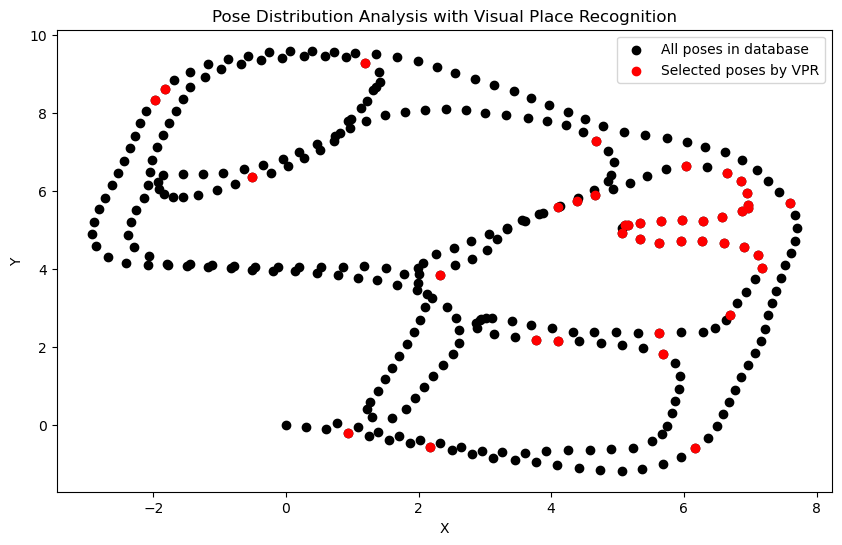

[ 4.95812277  4.79537551  0.01        0.          0.         -0.3488278
  0.93718684]


In [7]:
FILTER = False
EPS = 0.9
MIN_SAMPLES = 15
N = 5

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.jpg') or f.endswith('.png')]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224,3)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset, image_reloc_path):
    top_indices_all_queries = []
    first_image_indices = []
    last_image_indices = []
    sum_predict_time = 0
    features_matrix = np.array([])
    for i,image_reloc in enumerate(query_images_resnet):
    
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        #print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)

        print(resnet_feature[:5])
        
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        #print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        top_indices = similarities.argsort()[:N]
        if i == 0:
            first_image_indices = top_indices
        elif i == len(query_images_resnet) - 1:
            last_image_indices = top_indices
        
        start_time = time.time()
        top_indices_all_queries.extend(top_indices)
        end_time = time.time()
        #print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
    np.save(image_reloc_path,'features_matrix')
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries)), first_image_indices, last_image_indices

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    minimum_sample = MIN_SAMPLES
    result = np.array([])
    
    while minimum_sample > 0 and len(result) == 0:
        clustering = DBSCAN(eps=EPS, min_samples=minimum_sample).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
        result = np.array(top_indices_all_queries)[clustering.labels_ != -1]
        minimum_sample -= 1  # decrease minimum_sample

    return result

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, num_test,):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black', label='All poses in database')
    
    #plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green',s=100, label='Real robot poses (with AMCL)')
    if FILTER:
        plt.scatter(best_match_pose[0], best_match_pose[1], color='blue',s=100,marker='x', label='Predicted pose (centroid of cluster)')
        plt.title(f'Pose Distribution Analysis with Visual Place Recognition and DBSCAN - TEST {num_test}')
        plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red', label='Selected poses by VPR and DBSCAN')
    else:
        #plt.scatter(best_match_pose[0], best_match_pose[1], color='blue',s=100,marker='x', label='Predicted pose')
        plt.title(f'Pose Distribution Analysis with Visual Place Recognition')    
        plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red', label='Selected poses by VPR')   
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    print(best_match_pose)
    
def calculate_centroid(filtered_dataset, top_indices_all_queries, first_query_indices, last_query_indices):
    # Get the positions and orientations of the top_indices_all_queries
    centroid_pose = np.mean(filtered_dataset[top_indices_all_queries][:, 1:8], axis=0)
    #positions = filtered_dataset[top_indices_all_queries][:, 1:4]

    # Find the intersection of first_query_indices and last_query_indices with top_indices_all_queries
    first_query_indices = set(first_query_indices).intersection(top_indices_all_queries)
    last_query_indices = set(last_query_indices).intersection(top_indices_all_queries)

    # If both first_query_indices and last_query_indices are empty, use all orientations
    if not first_query_indices and not last_query_indices:
        orientations = filtered_dataset[top_indices_all_queries][:, 4:8]
    else:
        # Get the orientations of the intersected indices
        first_query_orientations = filtered_dataset[list(first_query_indices)][:, 4:8]
        last_query_orientations = filtered_dataset[list(last_query_indices)][:, 4:8]
        orientations = np.concatenate((first_query_orientations, last_query_orientations))
    # Convert the quaternions to Euler angles
    euler_angles = []
    for orientation in orientations:
        rotation = R.from_quat(orientation)
        euler_angles.append(rotation.as_euler('zyx'))

    # Calculate the mean of the z-axis rotation
    mean_z_rotation = np.mean([angle[0] for angle in euler_angles])

    # Convert the mean z-axis rotation back to a quaternion
    mean_rotation = R.from_euler('zyx', [mean_z_rotation, 0, 0])
    mean_quaternion = mean_rotation.as_quat()

    # Combine the centroid position and mean quaternion to form the centroid pose
    centroid_pose[3:8] = mean_quaternion
    return centroid_pose

if __name__ == "__main__":
    # Initialize models and datasets
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    for num_test in range(17, 18):
        # Load images
        #image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/test_{num_test}/'
        image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/test_debug/'
        query_images_resnet = load_images(image_reloc_path)

        # ResNet processing
        start_time_resnet = time.time()
        top_indices_all_queries, first_query_indices, last_query_indices = process_resnet(query_images_resnet, resnet, resnet_dataset,image_reloc_path)

        # DBSCAN filtering
        if FILTER:
            top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
        end_time_resnet = time.time()

        # Calculate centroid of the cluster of candidate poses
        start_time_sift = time.time()
        best_match_pose = calculate_centroid(filtered_dataset, top_indices_all_queries, first_query_indices, last_query_indices)
        #best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
        end_time_sift = time.time()

        # Print elapsed times
        print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
        print(f"Centroid:  {round(end_time_sift - start_time_sift, 3)} seconds") 
        print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

        # Plot results
        #real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
        #print(f'Last pose: {real_poses[-1]}')
        plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, num_test)

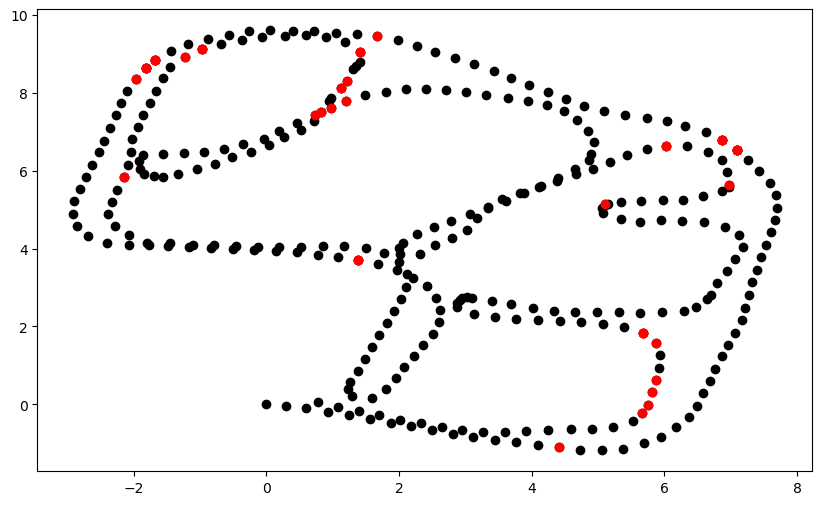

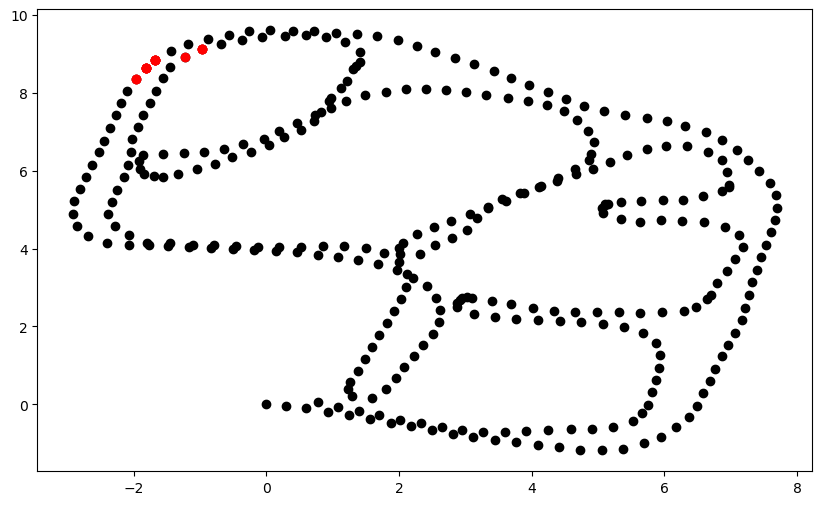

In [8]:
import numpy as np
from matplotlib import pyplot as plt
MIN_SAMPLES = 15
EPS = 0.9
image_dir = "/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/test_debug/"
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')
top_poses_index = np.load(image_dir + 'top_poses.npy')
top_poses = filtered_dataset[top_poses_index]
#print(top_poses)
plt.figure(figsize=(10, 6))
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black', label='All poses in database')
plt.scatter(top_poses[:,1].astype(float), top_poses[:,2].astype(float), color='red',label='Top poses')

minimum_samples = MIN_SAMPLES
result = np.array([])
while minimum_samples > 0 and len(result) == 0:
    clustering = DBSCAN(eps=EPS, min_samples=minimum_samples).fit(filtered_dataset[top_poses_index][:, 1:3])
    result = np.array(top_poses_index)[clustering.labels_ != -1]
    minimum_samples -= 1
top_poses_index = result
plt.figure(figsize=(10, 6))
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black', label='All poses in database')
plt.scatter(filtered_dataset[top_poses_index][:,1].astype(float), filtered_dataset[top_poses_index][:,2].astype(float), color='red',label='Top poses')


# Relocalization using VGG19

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
from scipy.spatial.transform import Rotation as R
import os
import time

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)
dataset_array[:2]

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-22 11:32:38.196903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 11:32:38.196959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 11:32:38.197697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 11:32:38.204668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

array([[ 0.00000000e+00,  1.26900955e-06, -1.88639280e-07,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -7.23014980e-02,  9.97382822e-01],
       [ 5.40000000e+01,  2.95406354e-01, -4.50266366e-02,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -7.90274330e-02,  9.96872442e-01]])

1/1 [==============================] - 0s 103ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/ste

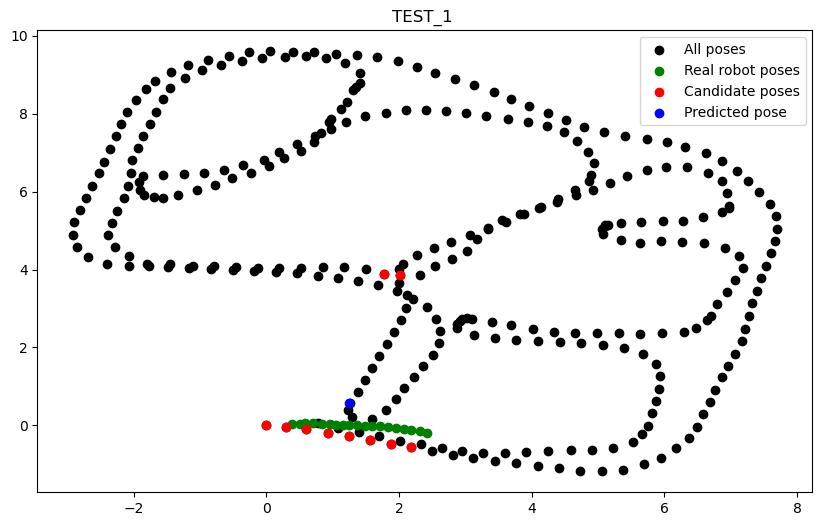

[ 1.24704458  0.56981501  0.01        0.          0.         -0.1491036
  0.98882158]
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 24ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] -

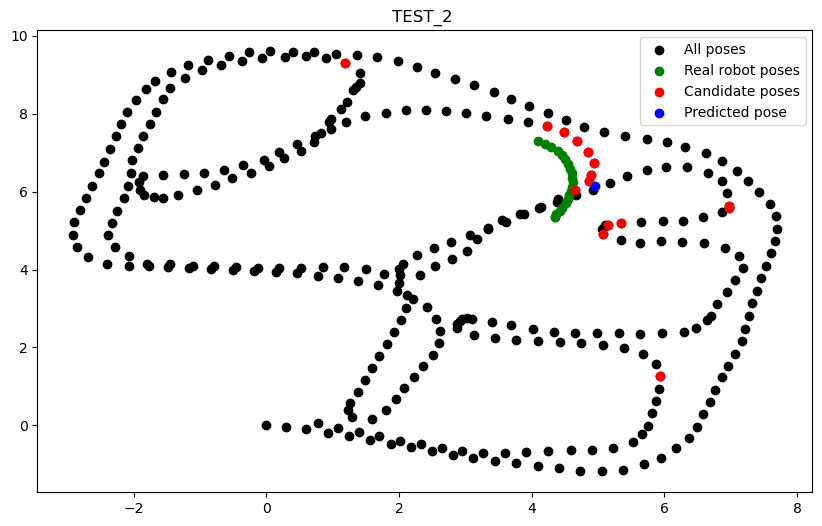

[ 4.94879669  6.1327631   0.01        0.          0.         -0.63117412
  0.77564117]
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 25ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 20ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 19ms/step
Similarities: 2.0 ms
1/1 [==============================] 

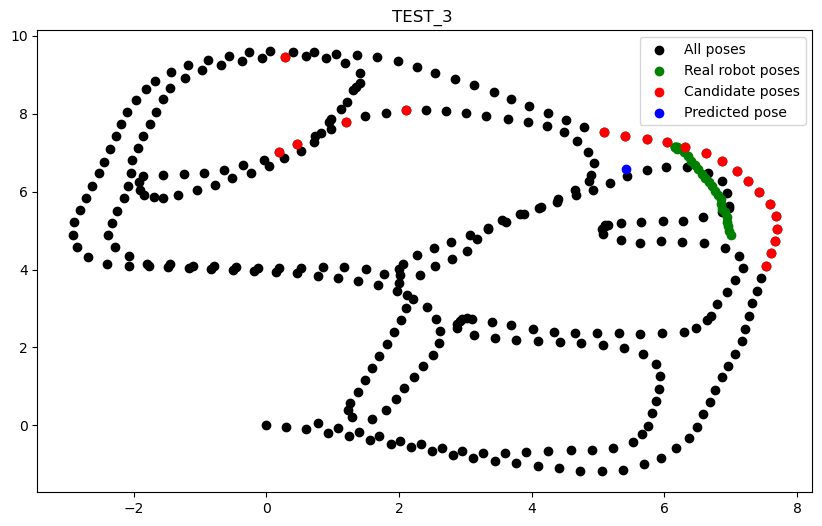

[5.4254217  6.58354082 0.01       0.         0.         0.7785302
 0.62760714]
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16m

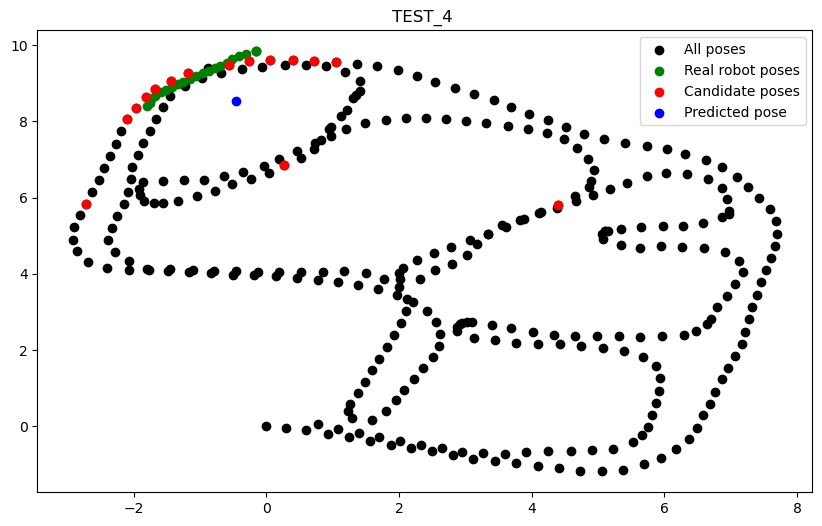

[-0.45804967  8.53700685  0.01        0.          0.         -0.40468476
  0.91445626]
1/1 [==============================] - 0s 21ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 21ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] 

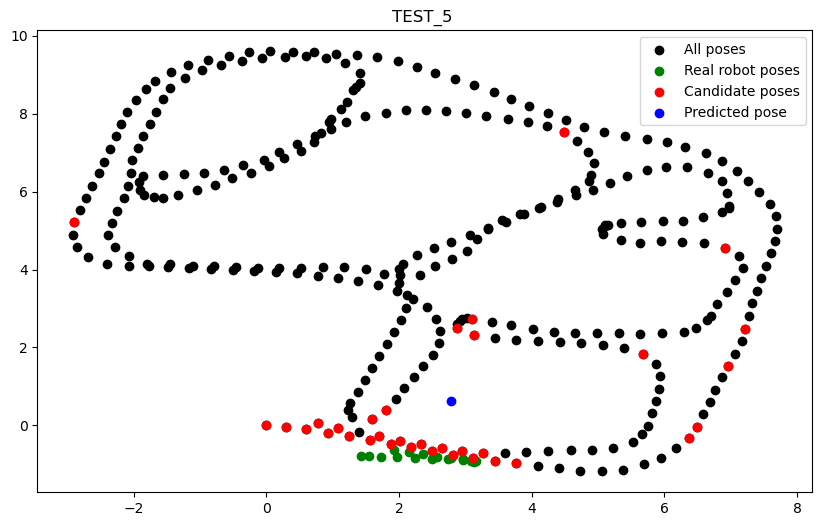

[ 2.7889306   0.63528759  0.01        0.          0.         -0.18491471
  0.98275457]
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 3.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] 

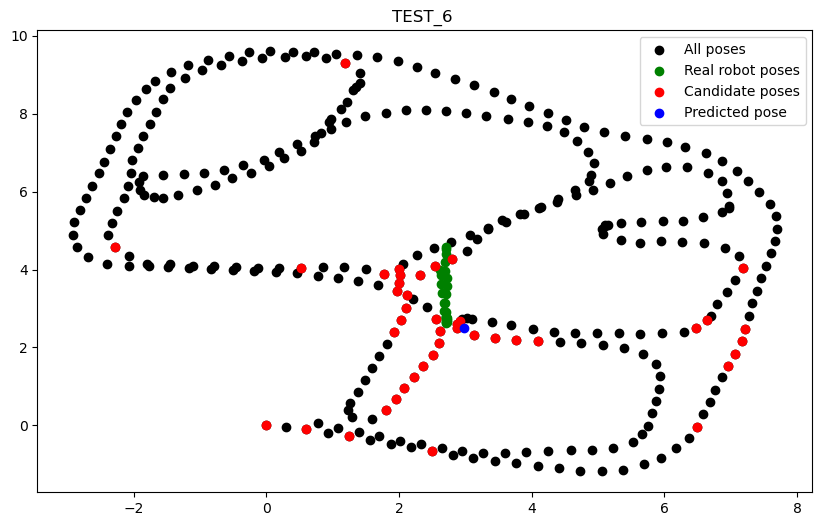

[ 2.9865036   2.49325423  0.01        0.          0.         -0.70793708
  0.7062755 ]
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 19ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] 

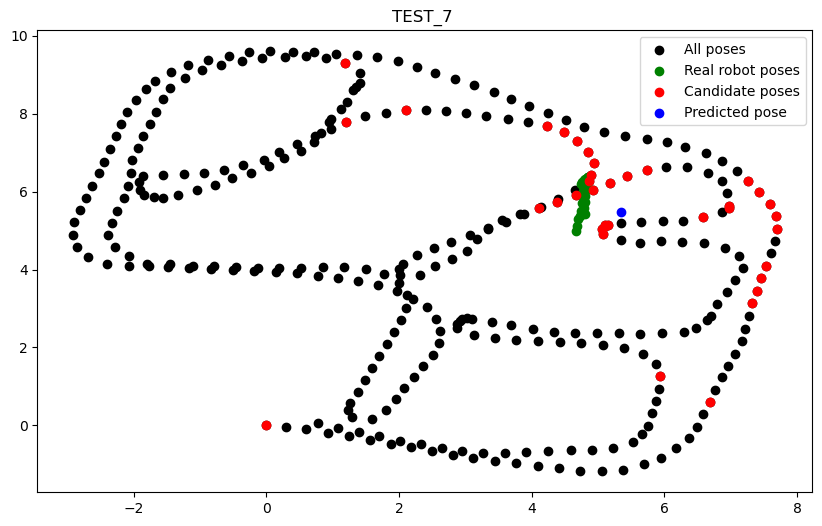

[ 5.3491483   5.49023605  0.01        0.          0.         -0.3714459
  0.9284546 ]
1/1 [==============================] - 0s 28ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 19ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 21ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] -

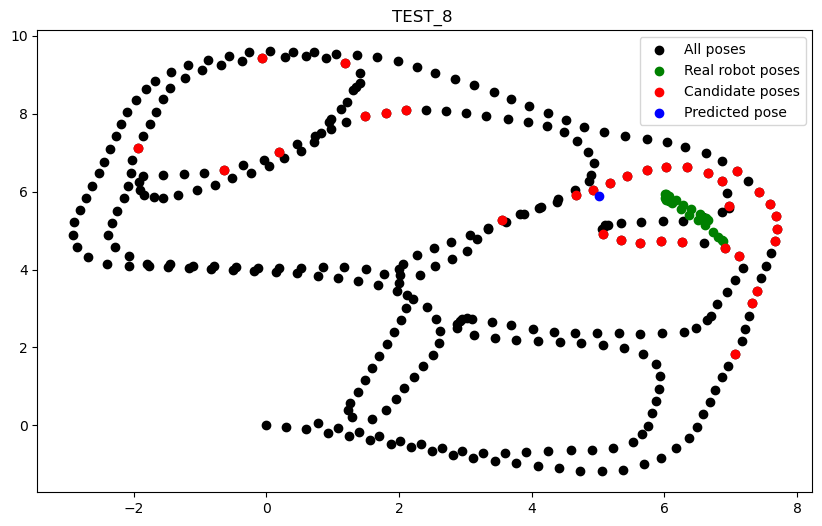

[5.02222746 5.88507691 0.01       0.         0.         0.44384751
 0.89610233]
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 19ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 5.0 ms
1/1 [==============================] - 0s 26ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16

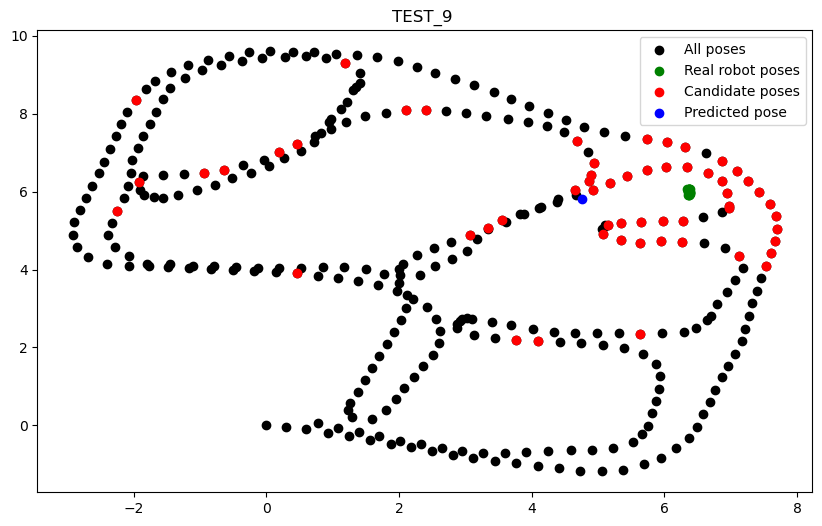

[ 4.75433708  5.80115281  0.01        0.          0.         -0.60713694
  0.79459722]
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] 

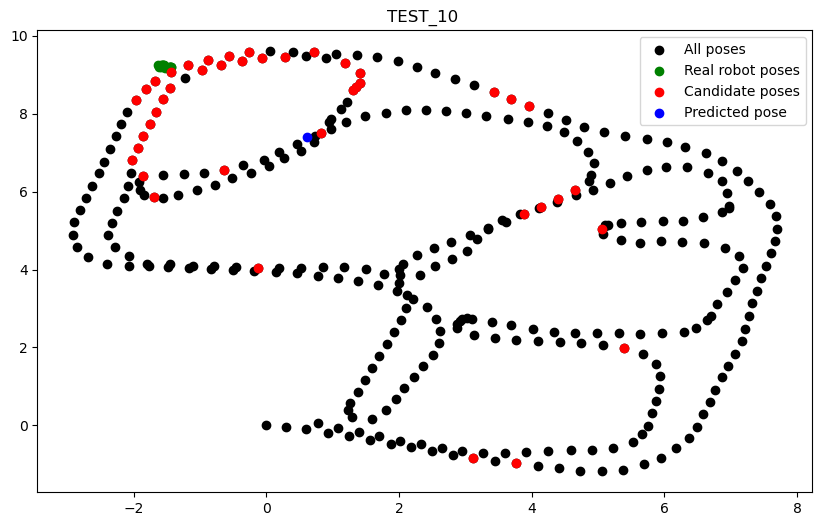

[ 0.60752375  7.40576425  0.01        0.          0.         -0.0139726
  0.99990238]
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] -

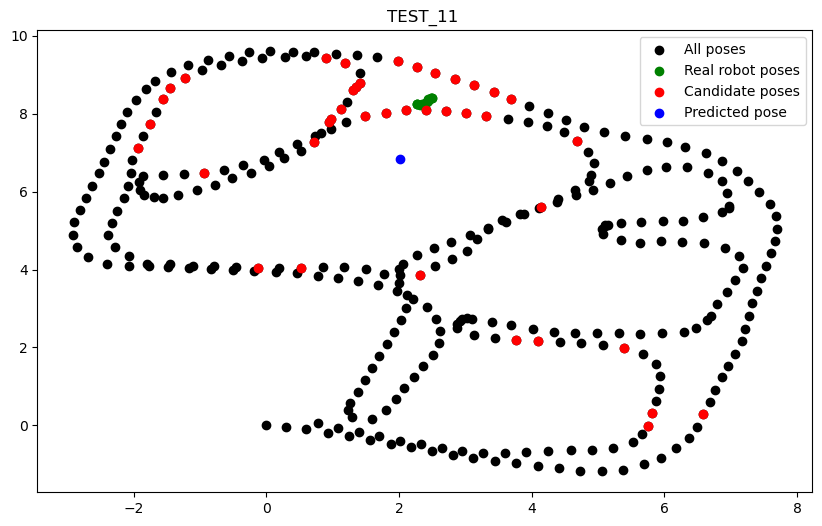

[2.01889423 6.8315546  0.01       0.         0.         0.67594704
 0.7369502 ]
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 19ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
Sum predict time:  0.8878681659698486
VGG19:

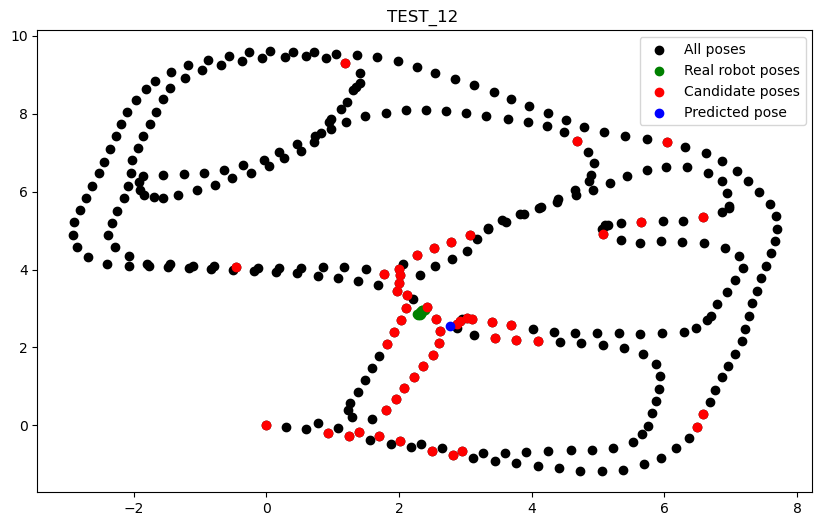

[ 2.769592    2.56312937  0.01        0.          0.         -0.13492827
  0.99085537]
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
Sum predict time:  0.8694696426391602

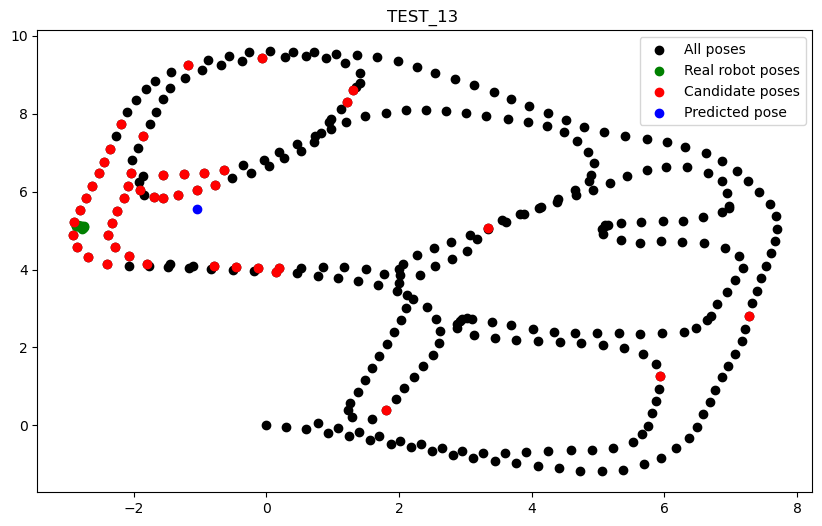

[-1.04022191  5.56395784  0.01        0.          0.          0.16322919
  0.98658818]
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 14ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 15ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 2.0 ms
1/1 [==============================] 

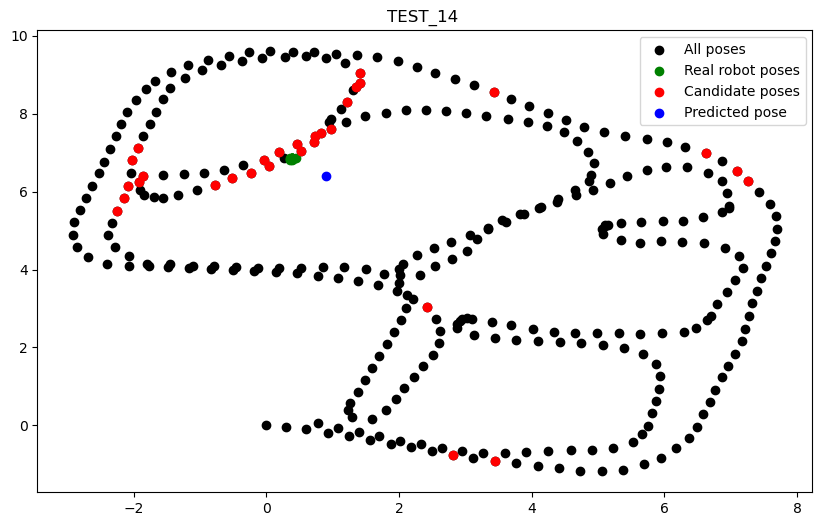

[0.90442538 6.40640027 0.01       0.         0.         0.55633746
 0.83095645]
1/1 [==============================] - 0s 36ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 20ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 2.0 ms
1/1 [==============================] - 0s 16ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 17ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 22ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 21ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Similarities: 1.0 ms
1/1 [==============================] - 0s 18

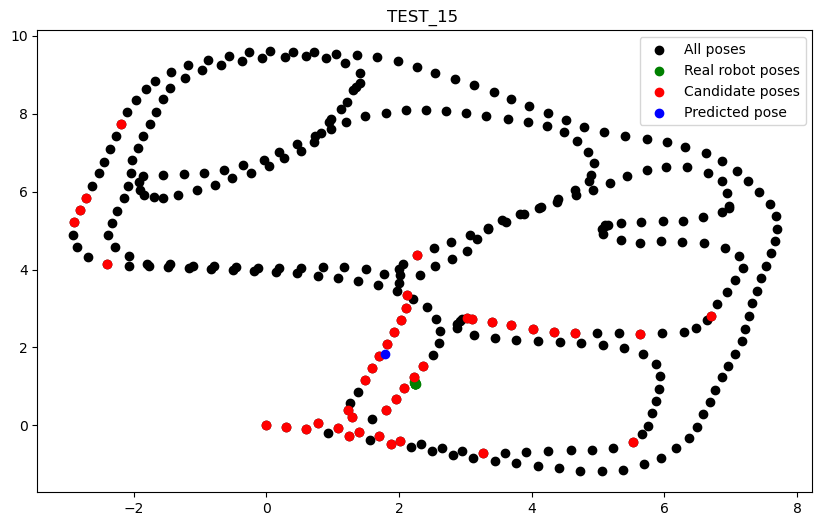

[1.79190743 1.82012982 0.01       0.         0.         0.74253871
 0.66980315]


In [16]:
FILTER = False
EPS = 0.9
MIN_SAMPLES = 20
N = 5

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.jpg') or f.endswith('.png')]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    first_image_indices = []
    last_image_indices = []
    sum_predict_time = 0
    for i,image_reloc in enumerate(query_images_vgg19):
    
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        #print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        #print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        top_indices = similarities.argsort()[:N]
        if i == 0:
            first_image_indices = top_indices
        elif i == len(query_images_resnet) - 1:
            last_image_indices = top_indices
        
        start_time = time.time()
        top_indices_all_queries.extend(top_indices)
        end_time = time.time()
        #print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")

    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries)), first_image_indices, last_image_indices

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    minimum_sample = MIN_SAMPLES
    result = np.array([])
    
    while minimum_sample > 0 and len(result) == 0:
        clustering = DBSCAN(eps=EPS, min_samples=minimum_sample).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
        result = np.array(top_indices_all_queries)[clustering.labels_ != -1]
        minimum_sample -= 1  # decrease minimum_sample

    return result

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, num_test,real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black', label='All poses')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green', label='Real robot poses')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red', label='Candidate poses')
    plt.scatter(best_match_pose[0], best_match_pose[1], color='blue', label='Predicted pose')
    plt.title(f'TEST_{num_test} ')
    plt.legend()
    plt.show()
    print(best_match_pose)
    
def calculate_centroid(filtered_dataset, top_indices_all_queries, first_query_indices, last_query_indices):
    # Get the positions and orientations of the top_indices_all_queries
    centroid_pose = np.mean(filtered_dataset[top_indices_all_queries][:, 1:8], axis=0)
    positions = filtered_dataset[top_indices_all_queries][:, 1:3]

    # Find the intersection of first_query_indices and last_query_indices with top_indices_all_queries
    first_query_indices = set(first_query_indices).intersection(top_indices_all_queries)
    last_query_indices = set(last_query_indices).intersection(top_indices_all_queries)

    # If both first_query_indices and last_query_indices are empty, use all orientations
    if not first_query_indices and not last_query_indices:
        orientations = filtered_dataset[top_indices_all_queries][:, 4:8]
    else:
        # Get the orientations of the intersected indices
        first_query_orientations = filtered_dataset[list(first_query_indices)][:, 4:8]
        last_query_orientations = filtered_dataset[list(last_query_indices)][:, 4:8]
        orientations = np.concatenate((first_query_orientations, last_query_orientations))

    # Convert the quaternions to Euler angles
    euler_angles = []
    for orientation in orientations:
        rotation = R.from_quat(orientation)
        euler_angles.append(rotation.as_euler('zyx'))

    # Calculate the mean of the z-axis rotation
    mean_z_rotation = np.mean([angle[0] for angle in euler_angles])

    # Convert the mean z-axis rotation back to a quaternion
    mean_rotation = R.from_euler('zyx', [mean_z_rotation, 0, 0])
    mean_quaternion = mean_rotation.as_quat()

    # Combine the centroid position and mean quaternion to form the centroid pose
    centroid_pose[3:8] = mean_quaternion

    # Calculate the mean distance of the xy positions from the centroid
    distances = np.sqrt(np.sum((positions - centroid_pose[1:3])**2, axis=1))
    mean_distance = np.mean(distances)

    # Print the inverse of the mean distance as the variance
    #print("Variance: ", (1/mean_distance)*10 if mean_distance != 0 else 0)

    return centroid_pose

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    for num_test in range(1, 16):
        # Load images
        image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/test_{num_test}/'
        query_images_vgg19 = load_images(image_reloc_path)

        # ResNet processing
        start_time_vgg19 = time.time()
        top_indices_all_queries, first_query_indices, last_query_indices = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

        # DBSCAN filtering
        if FILTER:
            top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
        end_time_vgg19 = time.time()

        # Calculate centroid of the cluster of candidate poses
        start_time_sift = time.time()
        best_match_pose = calculate_centroid(filtered_dataset, top_indices_all_queries, first_query_indices, last_query_indices)
        #best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
        end_time_sift = time.time()

        # Print elapsed times
        print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
        print(f"Centroid:  {round(end_time_sift - start_time_sift, 3)} seconds") 
        print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

        # Plot results
        real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
        print(f'Last pose: {real_poses[-1]}')
        plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, num_test, real_poses)